In [17]:
import matplotlib.pyplot as plt
import numpy as np

import cmbo
from IPython.display import display

from plot_stacked import *
from score_individual_objects import *
from prob_match import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(2493,) (2493,) (2493,)
(820,) (820,) (820,) (820,)


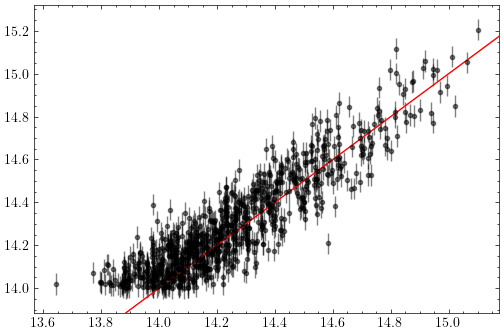

In [20]:
mockgen = MockGenerator()

mock_kwargs = {
    "log_mmin": 13,
    "log_mmax": 16,
    "volume": 500**3,
    "log_m_cut_true": None,
    "log_m_cut_obs": 14,
    "scatter_dex": 0.1,
    "meas_err_dex": 0.05,
}

x, y, yerr = mockgen.make_mock(**mock_kwargs, seed=1)
print(x.shape, y.shape, yerr.shape)

x, y, yerr, pmatch = mockgen.simulate_incomplete_matching(
    x, y, yerr, completeness=0.76, mass_dependent=True, mass_scale=14.3,
    use_observed=True)
print(x.shape, y.shape, yerr.shape, pmatch.shape)

xmean = x.mean()
x -= xmean

truths = [0 + xmean, 0.1, 1.0]


plt.figure(figsize=(6, 4))
plt.errorbar(x + xmean, y, yerr=yerr, fmt=".k", alpha=0.5)

plt.axline([14.4, 14.4], slope=1, color='red')

plt.show()


In [21]:
fitter = ScalingRelationFitter()

mcmc = fitter.fit(
    x, y, yerr, ymin=mock_kwargs["log_m_cut_obs"],
    num_warmup=1000, num_samples=2500,
    completeness=0.76, match_on_y=True, mass_scale=14.3)
mcmc.print_summary()
samples = mcmc.get_samples()


sample: 100%|██████████| 3500/3500 [00:01<00:00, 2592.51it/s, 1 steps of size 2.23e-308. acc. prob=0.00]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept    -50.00      0.00    -50.00    -50.00    -50.00       nan       nan
      sigma      0.50      0.00      0.50      0.50      0.50       nan       nan
      slope      2.00      0.00      2.00      2.00      2.00      1.00      1.00

Number of divergences: 2500


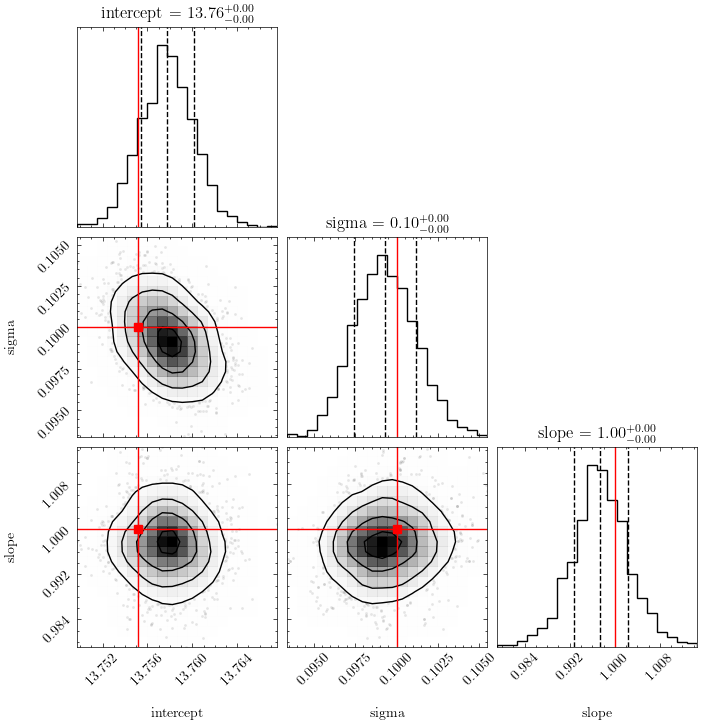

In [6]:
fig = make_corner_plot(samples, truths=truths)

display(fig)

In [ ]:
cfg = cmbo.utils.load_config("/Users/rstiskalek/Projects/CMBOlympics/scripts/config.toml")
data_MCXC = cmbo.io.load_mcxc_catalogue(cfg['paths']['MCXC_catalogue'])

In [ ]:
logL = np.log10(data_MCXC["L500"] * 0.68)
elogL = data_MCXC["eL500"] / (data_MCXC["L500"] * np.log(10))


x_obs = cmbo.utils.radec_to_cartesian(data_MCXC['RA'], data_MCXC['DEC'])
x_obs *= cmbo.utils.cz_to_comoving_distance(data_MCXC['Z'] * cmbo.constants.SPEED_OF_LIGHT_KMS)[:, None]

mask = (data_MCXC['M500'] >= 1e14) & (data_MCXC['Z'] <= 0.05)
x_obs = x_obs[mask]
x_obs += 681.1 / 2


In [ ]:
x_halo, masses = cmbo.io.load_halo_positions_masses(
    "/Users/rstiskalek/Projects/CMBOlympics/data/manticore_fof.hdf5",
    "Coordinates", "Group_M_Crit200", nsim=0, r_max=1000, mass_min=1e10
    )


# x_halo = x_obs + 0.1


In [ ]:
np.savez("matching_halos_data.npz", x_halo=x_halo, masses=masses)

In [ ]:
np.savez("matching_halos_data.npz", x_halo=x_halo, x_obs=x_obs, logL=logL[mask], elogL=elogL[mask], halo_masses=masses, xray_masses=data_MCXC['M500'][mask])

In [ ]:
x_halo.shape

In [ ]:
groups = cmbo.match.fof_tessellation(x_obs, x_halo, linking_length=3)
groups_prob = cmbo.match.compute_group_probabilities(x_obs, x_halo, 1, groups)

In [ ]:
# model = cmbo.match.AssociationModel(groups, groups_prob)

model = cmbo.match.ScalingRelationModel(groups, groups_prob, logL - 44, 0.01 * elogL, logL - 44 + 0.01)

In [ ]:
mcmc = model.run()
mcmc.print_summary()
samples = mcmc.get_samples()

In [ ]:
plt.figure()
plt.hist(samples['p_null'], bins=30)
plt.show()

In [ ]:
matches = model.get_best_matches(samples['p_null'])
matches

In [ ]:
results = model.get_association_probabilities(samples['p_null'])

In [ ]:
results

In [ ]:
plt.figure()
plt.hist(samples["p_null"], bins="auto")
plt.show()

In [ ]:
# total = 0
# for obs_idx, halo_idx in groups:
#     n_assignments = len(cmbo.match.generate_valid_assignments(len(obs_idx), len(halo_idx)))
#     total += n_assignments
#     print(f"Group ({len(obs_idx)} obs, {len(halo_idx)} halos): {n_assignments} assignments")

# print(f"Total assignments: {total}")


In [ ]:
res[1]

In [ ]:
groups[1]

In [ ]:
sum([len(gr[1]) for gr in groups])

In [ ]:
len(x_halo)

In [ ]:
len(x_obs)

In [ ]:
groups[0]